Testing Guney's `toolbox` package for network based proximity between drug targets and disease genes.

Chosen targets:
* Hydroxychloroquine targets (TLR7 and TLR9)
* two of the AD disease genes

AD disease genes:
* Guney AD genes: from Guney et al
* Knowledge based AD genes: from the DISEASES database
* High confidence AD genes: knowledge based + TWAS + incipient proteomic signature

Both choices of targets are rather arbitrary.  We expect the two AD disease genes, by definition, to be more proximal than the Hydroxychloroquine targets (which are not AD genes by any definition used in this notebook). The calculations below will support this quantitatively.

In [1]:
%load_ext autoreload
%autoreload 2
%reload_ext autoreload
from toolbox import wrappers
from toolbox import network_utilities
import pandas as pd
import numpy as np
import scipy.stats
from matplotlib_venn import venn2, venn3
import matplotlib.pyplot as plt
import seaborn as sns
import attila_utils
import repos_tools

GenRev not found, steiner wont work
Import error: Negex. Using keyword matching instead
Import error: Funcassociate. Make sure that funcassociate is in toolbox!


## Preparations

### GeneID -- Symbol mapping

`id_mapping_file` comes from [this file](ftp://ftp.ncbi.nih.gov/gene/DATA/GENE_INFO/Mammalia/Homo_sapiens.gene_info.gz) at NCBI; see [parse_ncbi.py](https://github.com/attilagk/guney_code/blob/master/parse_ncbi.py) for details.

In [2]:
id_mapping_file = '../../resources/PPI/geneid_to_symbol.txt'
id_symbol = pd.read_csv(id_mapping_file, sep='\t', index_col='GeneID')
id_symbol = id_symbol.set_index(id_symbol.index.astype('str'))
id_symbol

,Symbol
GeneID,
1,A1BG
2,A2M
3,A2MP1
9,NAT1
10,NAT2
...,...
8923215,trnD
8923216,trnP
8923217,trnA


### PPI networks

I read two PPI networks:
1. `network_guney` from Guney et al 2016
1. `network_cheng` from Cheng et al 2019

Below is the number of binary PPI interactions in each of these networks

In [3]:
%%bash
wc -l ../../resources/proximity/data/network/network.sif ../../resources/PPI/Cheng2019/network.sif

 141296 ../../resources/proximity/data/network/network.sif
 217160 ../../resources/PPI/Cheng2019/network.sif
 358456 total


In [4]:
network_guney = wrappers.get_network('../../resources/proximity/data/network/network.sif', only_lcc = True)
network_cheng = wrappers.get_network('../../resources/PPI/Cheng2019/network.sif', only_lcc = True)

### HCQ targets
I will use Hydroxychloroquine's targets.  See [this page](https://go.drugbank.com/drugs/DB01611) on drugbank.

In [5]:
%%bash
echo TLR7 > ../../results/2021-08-04-guney-tools/Hydroxychloroquine-targets
echo TLR9 >> ../../results/2021-08-04-guney-tools/Hydroxychloroquine-targets

In [6]:
HCQ_targets_TLR = wrappers.convert_to_geneid(file_name='../../results/2021-08-04-guney-tools/Hydroxychloroquine-targets', id_type='symbol', id_mapping_file=id_mapping_file)
HCQ_targets_TLR

set()


{'51284', '54106'}

In [7]:
%%bash
echo ACE2 >> ../../results/2021-08-04-guney-tools/Hydroxychloroquine-targets

In [8]:
HCQ_targets = wrappers.convert_to_geneid(file_name='../../results/2021-08-04-guney-tools/Hydroxychloroquine-targets', id_type='symbol', id_mapping_file=id_mapping_file)
HCQ_targets

set()


{'51284', '54106', '59272'}

### AD gene sets
#### Guney AD genes

In [9]:
%%bash
grep 'alzheimer disease' ../../resources/proximity/data/disease/disease_genes.tsv | \
tr '\t' '\n' | sed -n '/^[0-9]\+/ p' > ../../results/2021-08-04-guney-tools/AD-genes-guney

In [10]:
with open('../../results/2021-08-04-guney-tools/AD-genes-guney') as f:
    AD_genes_guney = f.readlines()
AD_genes_guney = [x.strip('\n') for x in AD_genes_guney]

Making sure that the gene set is a subset of the network's nodes

In [11]:
def remove_genes_notin_network(genes, network):
    oldsize = len(genes)
    newgenes = [y for y in genes if y in network.nodes]
    newsize = len(newgenes)
    restgenes = set(genes).difference(set(newgenes))
    print(oldsize - newsize, 'genes removed from', oldsize)
    return((newgenes, restgenes))

AD_genes_guney, AD_genes_guney_removed = remove_genes_notin_network(AD_genes_guney, network_cheng)

5 genes removed from 36


When I use the older, smaller `network_guney` then additional genes are removed (therefore I won't use `network_guney`).

In [12]:
AD_genes_guney1, AD_genes_guney_removed1 = remove_genes_notin_network(AD_genes_guney, network_guney)

2 genes removed from 31


In [13]:
gset_names = ['knowledge', 'knowledge-TWAS2plus', 'knowledge-TWAS', 'knowledge-TWAS2plus-IAPS']
def read_geneset(name):
    file_name = '../../results/2021-07-01-high-conf-ADgenes/AD-genes-' + name
    gset = wrappers.convert_to_geneid(file_name=file_name, id_type='symbol', id_mapping_file=id_mapping_file)
    gset, gset_dropped = repos_tools.drop_genes_notin_network(gset, network_cheng)
    return(gset)

Genesets = {k: read_geneset(k) for k in gset_names}
Genesets.update({'Guney': AD_genes_guney})

{'MT-ND2', 'MT-ND1'}
{'MT-ND2', 'MT-ND1'}
{'CTB-129P6.11', 'CTD-2380F24.1', 'FAM115D', 'ENSG00000260911', 'AL512631.1', 'MT-ND2', 'RP11-385F7.1', 'X84075', 'MT-ND1', 'AC087500.1', 'ENSG00000270081.1', 'AC099524.1', 'GATS', 'RTFDC1'}
{'MT-ND2', 'MT-ND1'}


## Results

### Overlap between AD gene sets

Relationship of various AD gene sets are plotted below

['named-figure/AD-gene-sets-venn2.png', 'named-figure/AD-gene-sets-venn2.pdf']

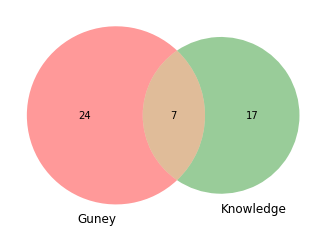

In [14]:
G = set(Genesets['Guney'])
K = set(Genesets['knowledge'])
H = set(Genesets['knowledge-TWAS2plus'])

def get_subsets2(A, B):
    partition = dict()
    partition['10'] = A.difference(B)
    partition['01'] = B.difference(A)
    partition['11'] = A.intersection(B)
    subsets = {k: len(v) for k, v in partition.items()}
    return(subsets)

fig, ax = plt.subplots()
subsets = get_subsets2(A=set(Genesets['Guney']), B=set(Genesets['knowledge']))
venn2(subsets=subsets, set_labels=('Guney', 'Knowledge'))
attila_utils.savefig(fig, 'AD-gene-sets-venn2')

The intersection contains APP, APOE and PSEN1, PSEN2.

written to AD-gene-sets-venn3-TWAS2plus


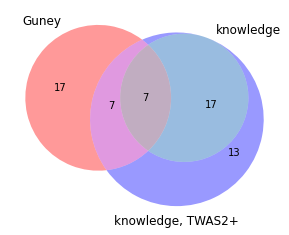

In [15]:
def get_subsets3(A, B, C):
    partition = dict()
    partition['100'] = A.difference(B.union(C))
    partition['010'] = B.difference(A.union(C))
    partition['001'] = C.difference(A.union(B))
    partition['110'] = A.intersection(B).difference(C)
    partition['101'] = A.intersection(C).difference(B)
    partition['011'] = B.intersection(C).difference(A)
    partition['111'] = A.intersection(B).intersection(C)
    subsets = {k: len(v) for k, v in partition.items()}
    return(subsets)

def plot_subsets3(Cname='TWAS2plus', Lname='TWAS2+'):
    fig, ax = plt.subplots()
    subsets = get_subsets3(A=set(Genesets['Guney']), B=set(Genesets['knowledge']), C=set(Genesets['knowledge-' + Cname]))
    venn3(subsets=subsets, set_labels=('Guney', 'knowledge', 'knowledge, ' + Lname))
    fname = 'AD-gene-sets-venn3-' + Cname
    attila_utils.savefig(fig, fname)
    print('written to', fname)

plot_subsets3(Cname='TWAS2plus', Lname='TWAS2+')

written to AD-gene-sets-venn3-TWAS


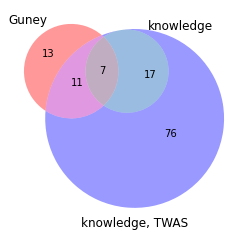

In [16]:
plot_subsets3(Cname='TWAS', Lname='TWAS')

written to AD-gene-sets-venn3-TWAS2plus-IAPS


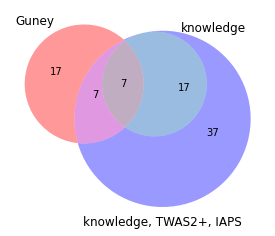

In [17]:
plot_subsets3(Cname='TWAS2plus-IAPS', Lname='TWAS2+, IAPS')

### Node degree

In [18]:
G_knowledge = network_utilities.get_neighborhood_subgraph(network_cheng, Genesets['knowledge'])
degrees_knowledge = network_utilities.get_node_degree_related_values(G_knowledge, set())

In [19]:
dk = pd.DataFrame(degrees_knowledge).transpose().rename({0: 'd', 1: 'ld', 2: 'd2', 3: 'ld2'}, axis=1)
ik = id_symbol.loc[list(set(Genesets['Guney']).intersection(set(Genesets['knowledge']))), ]
pd.concat([ik, dk.loc[ik.index, ]], axis=1)

,Symbol,d,ld,d2,ld2
GeneID,,,,,
5663,PSEN1,108,0,2917,0
348,APOE,62,0,2882,0
1191,CLU,82,0,2858,0
351,APP,1967,0,3020,0
10347,ABCA7,5,0,1985,0
55103,RALGPS2,5,0,2014,0
5664,PSEN2,68,0,2841,0


Now the same for all knowledge based genes

['named-figure/degree-knowledge.png', 'named-figure/degree-knowledge.pdf']

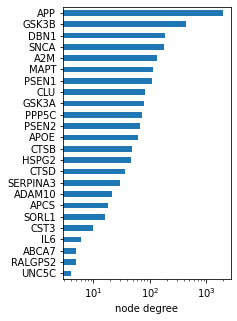

In [58]:
ik = id_symbol.loc[list(set(Genesets['knowledge'])), ]
d_knowledge = pd.concat([ik, dk.loc[ik.index, ]], axis=1)
d_knowledge = d_knowledge.rename(d_knowledge.Symbol, axis=0)
d_knowledge = d_knowledge.sort_values('d').drop(['Symbol', 'ld', 'd2', 'ld2'], axis=1)
d_knowledge = d_knowledge.rename_axis('')
fig, ax = plt.subplots(figsize=(3, 5))
ax.set_xlabel('node degree')
d_knowledge.plot(kind='barh', legend=False, logx=True, ax=ax)
attila_utils.savefig(fig, 'degree-knowledge')

In [20]:
G_HCQ = network_utilities.get_neighborhood_subgraph(network_cheng, HCQ_targets)
degrees_HCQ = network_utilities.get_node_degree_related_values(G_HCQ, set())

Let's calculate the degree of TLR7 and TLR9!

In [21]:
dh = pd.DataFrame(degrees_HCQ).transpose().rename({0: 'd', 1: 'ld', 2: 'd2', 3: 'ld2'}, axis=1)
ih = id_symbol.loc[HCQ_targets, ]
pd.concat([ih, dh.loc[ih.index, ]], axis=1)

,Symbol,d,ld,d2,ld2
GeneID,,,,,
54106,TLR9,28,0,33,0
59272,ACE2,5,0,10,0
51284,TLR7,6,0,19,0


I select ABCA7 and APOE, two AD genes with comparable degrees to TLR7 and TLR9, respectively:

In [22]:
AD_3genes = {'10347', '348', '55103'}
Targets = {'HCQ targets': HCQ_targets, 'HCQ t: TLRs': HCQ_targets_TLR, '3 AD genes': AD_3genes}

### Proximity

Now the proximity calculation between `HCQ_targets` and `AD_genes_guney`

In [23]:
def helper(target, geneset, network):
    res = wrappers.calculate_proximity(network=network, nodes_from=target, nodes_to=geneset)
    return(res)

def dict2df(d, condition):
    l = [[v[0], v[1], v[2][0], v[2][1]] for v in d.values()]
    a = np.array(l)
    ix = pd.MultiIndex.from_product([[condition], d.keys()])
    # z = (d - mean_0) / std_0
    df = pd.DataFrame(a, columns=['d', 'z', 'mean_0', 'std_0'], index=ix)
    df['p'] = df['z'].apply(lambda x: scipy.stats.norm.sf(-x))
    df = df.rename_axis(['condition', 'target'], axis=0)
    return(df)

Prox = {gname: dict2df({tname: helper(targ, gset, network_cheng) for tname, targ in Targets.items()}, gname) for gname, gset in Genesets.items()}

In [24]:
prox = pd.concat(Prox.values(), axis=0)
prox.to_csv('../../results/2021-08-04-guney-tools/proximity-results.csv')
prox['condition'] = pd.MultiIndex.get_level_values(prox.index, level='condition')
prox['target'] = pd.MultiIndex.get_level_values(prox.index, level='target')
prox

d         z    mean_0     std_0  \
condition                target                                                
knowledge                HCQ targets  2.333333  1.588436  1.985667  0.218874   
                         HCQ t: TLRs  2.500000  2.209118  1.934000  0.256211   
                         3 AD genes   0.000000 -7.743758  1.942667  0.250869   
knowledge-TWAS2plus      HCQ targets  2.000000  0.252392  1.942667  0.227160   
                         HCQ t: TLRs  2.000000  0.309227  1.919500  0.260326   
                         3 AD genes   0.000000 -7.459232  1.892000  0.253645   
knowledge-TWAS           HCQ targets  2.000000  0.418478  1.899333  0.240554   
                         HCQ t: TLRs  2.000000  0.513298  1.851500  0.289306   
                         3 AD genes   0.000000 -7.051715  1.810667  0.256770   
knowledge-TWAS2plus-IAPS HCQ targets  2.000000  0.569999  1.856667  0.251462   
                         HCQ t: TLRs  2.000000  0.624760  1.805500  0.311319   
                         3 AD genes   0.000000 -6.718122  1.772000  0.263764   
Guney                    HCQ targets  2.333333  1.398229  2.016333  0.226715   
                         HCQ t: TLRs  2.000000  0.155230  1.960000  0.257682   
                         3 AD genes   0.000000 -8.326484  1.975333  0.237235   

                                                 p                 condition  \
condition                target                                                
knowledge                HCQ targets  9.439061e-01                 knowledge   
                         HCQ t: TLRs  9.864168e-01                 knowledge   
                         3 AD genes   4.826022e-15                 knowledge   
knowledge-TWAS2plus      HCQ targets  5.996308e-01       knowledge-TWAS2plus   
                         HCQ t: TLRs  6.214257e-01       knowledge-TWAS2plus   
                         3 AD genes   4.351419e-14       knowledge-TWAS2plus   
knowledge-TWAS           HCQ targets  6.622013e-01            knowledge-TWAS   
                         HCQ t: TLRs  6.961286e-01            knowledge-TWAS   
                         3 AD genes   8.836273e-13            knowledge-TWAS   
knowledge-TWAS2plus-IAPS HCQ targets  7.156608e-01  knowledge-TWAS2plus-IAPS   
                         HCQ t: TLRs  7.339358e-01  knowledge-TWAS2plus-IAPS   
                         3 AD genes   9.204102e-12  knowledge-TWAS2plus-IAPS   
Guney                    HCQ targets  9.189778e-01                     Guney   
                         HCQ t: TLRs  5.616800e-01                     Guney   
                         3 AD genes   4.163952e-17                     Guney   

                                           target  
condition                target                    
knowledge                HCQ targets  HCQ targets  
                         HCQ t: TLRs  HCQ t: TLRs  
                         3 AD genes    3 AD genes  
knowledge-TWAS2plus      HCQ targets  HCQ targets  
                         HCQ t: TLRs  HCQ t: TLRs  
                         3 AD genes    3 AD genes  
knowledge-TWAS           HCQ targets  HCQ targets  
                         HCQ t: TLRs  HCQ t: TLRs  
                         3 AD genes    3 AD genes  
knowledge-TWAS2plus-IAPS HCQ targets  HCQ targets  
                         HCQ t: TLRs  HCQ t: TLRs  
                         3 AD genes    3 AD genes  
Guney                    HCQ targets  HCQ targets  
                         HCQ t: TLRs  HCQ t: TLRs  
                         3 AD genes    3 AD genes

['named-figure/proximity-d-z-p-TLRs.png',
 'named-figure/proximity-d-z-p-TLRs.pdf']

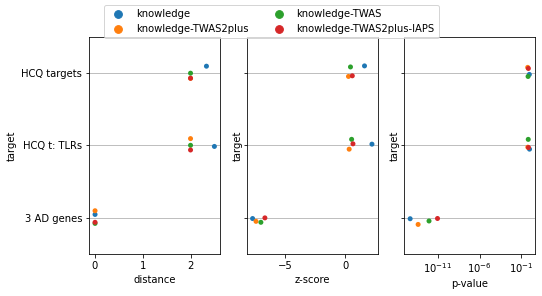

In [25]:
fig, ax = repos_tools.plot_proximity_results(prox.drop('Guney', level=0))
attila_utils.savefig(fig, 'proximity-d-z-p-TLRs')

['named-figure/proximity-d-z-p.png', 'named-figure/proximity-d-z-p.pdf']

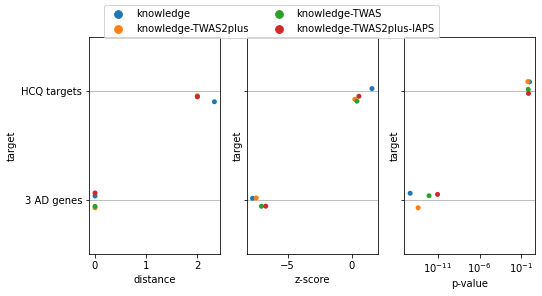

In [26]:
fig, ax = repos_tools.plot_proximity_results(prox.drop('Guney', level=0).drop(labels='HCQ t: TLRs', axis=0, level='target'))
attila_utils.savefig(fig, 'proximity-d-z-p')

## TODO

* Download and parse drugbank. See [drugbank-downloader](https://pypi.org/project/drugbank-downloader/)
* deploy `wrappers.calculate_proximity` to cloud

In [27]:
%connect_info

{
  "shell_port": 42309,
  "iopub_port": 34281,
  "stdin_port": 52267,
  "control_port": 45057,
  "hb_port": 57761,
  "ip": "127.0.0.1",
  "key": "9403e5e4-b7183eea962fbfc3da2ed1af",
  "transport": "tcp",
  "signature_scheme": "hmac-sha256",
  "kernel_name": ""
}

Paste the above JSON into a file, and connect with:
    $> jupyter <app> --existing <file>
or, if you are local, you can connect with just:
    $> jupyter <app> --existing kernel-9e8a6c79-f758-47f1-917b-317fae7a4bf9.json
or even just:
    $> jupyter <app> --existing
if this is the most recent Jupyter kernel you have started.
